In [9]:
import numpy as np
from probDE.Examples.fitz_plot import fitz_plot
from probDE.Kalman.ode_init import car_init, indep_ode_init
from probDE.cython.KalmanTest.KalmanODE import KalmanODE

In [2]:
def fitz(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    V, R = X_t[0], X_t[n_state1]
    return np.array([c*(V - V**3/3 + R), -1/c*(V - a + b*R)])

In [3]:
# These parameters define the order of the ODE and the CAR(p) process
n_state1 = 3 # State dimension of V_n
n_state2 = 3 # State dimension of R_n
n_state = 6 # Total state
n_meas = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
h = 0.1 # step size
n_eval = int((tmax-tmin)/h)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, a, for the IVP
x0 = [-1, 1]
v0 = [1, 1/3]
X0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])

# logprior parameters
theta_true = np.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_sd = np.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

In [4]:
# initialize fitz_plot class and simulate date via odeint
fplot = fitz_plot(n_state1, tmin, tmax)
Y_t, X_t = fplot.simulate(x0, theta_true, gamma)

In [5]:
# Euler simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_euler = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    phi_hat, phi_var = fplot.phi_fit(fplot.euler_nlpost, Y_t, x0, hlst[i], theta_true, phi_sd, gamma)
    Theta_euler[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

In [10]:
# Kalman simulation
hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
Theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    kinit = indep_ode_init([car_init(n_state1, tau[0], sigma[0], hlst[i], w_mat[0], X0[0]),
                            car_init(n_state2, tau[1], sigma[1], hlst[i], w_mat[1], X0[1])],
                            n_state)
    x0_state = kinit[-1]
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE.initialize(kinit, n_state, n_meas, tmin, tmax, n_eval, fitz)
    fplot.kode = kode
    phi_hat, phi_var = fplot.phi_fit(fplot.kalman_nlpost, Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma)
    Theta_kalman[i] = fplot.Theta_sample(phi_hat, phi_var, n_samples)

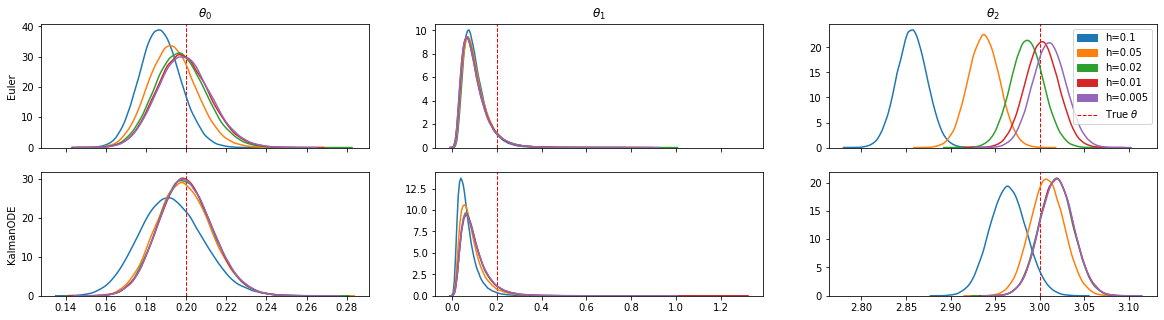

In [11]:
# Euler, Kalman plots
fplot.theta_plot(Theta_euler, Theta_kalman, theta_true, hlst)

# Tests

In [ ]:
def quadratic(X):
    return np.sum(X**2)

In [ ]:
def cubic(X):
    return (X[0]**3)*(X[1]**2)

In [ ]:
def cubic_hes(X):
    return np.array([[6*X[0]*X[1]**2, 6*X[0]**2*X[1]], [6*X[0]**2*X[1], 2*X[0]**3]])

In [ ]:
rosen = lambda x : (1.-x[0])**2 + 105*(x[1]-x[0]**2)**2
numHess(rosen, np.array([1, 1]))

In [ ]:
def numHess(func, x):
    if not np.isscalar(func(x)):
        raise ValueError('Richardson method for Hessian assumes a scalar valued function.')
    D = genD(func, x)
    H = np.zeros((len(x), len(x)))
    u = len(x)-1
    for i in range(len(x)):
        for j in range(i+1):
            u+=1
            H[i, j] = D[u]
    H = H + H.T
    np.fill_diagonal(H, np.diag(H)/2)
    return H

In [ ]:
def genD(func, x):
    eps = 1e-4
    d = 0.1
    zeroTol = np.sqrt(eps/(7e-7))
    r = 4
    v = 2
    x = x.astype(float)
    f0 = func(x)
    
    n = len(x)
    h0 = np.abs(d*x) + eps * (np.abs(x) < zeroTol)
    D = np.zeros(int(n*(n + 3)/2))
    Dapprox = np.zeros(r)
    Hdiag = np.zeros(n)
    Happrox = np.zeros(r)
    
    for i in range(n):
        h = h0
        for k in range(r):
            x1 = x.copy()
            x1[i] += h[i]
            x2 = x.copy()
            x2[i] -= h[i]
            f1 = func(x1)
            f2 = func(x2)
            Dapprox[k] = (f1 - f2) / (2*h[i])
            Happrox[k] = (f1 - 2*f0 + f2) / h[i]**2
            h = h/v
        for m in range(r-1):
            for k in range(r-m-1):
                Dapprox[k] = (Dapprox[k+1]*(4**(m+1)) - Dapprox[k])/(4**(m+1)-1)
                Happrox[k] = (Happrox[k+1]*(4**(m+1)) - Happrox[k])/(4**(m+1)-1)
        D[i] = Dapprox[0]
        Hdiag[i] = Happrox[0]
    u = n-1
    for i in range(n):
        for j in range(i+1):
            u+=1
            if i==j:
                D[u] = Hdiag[i]
            else:
                h = h0
                for k in range(r):
                    x1 = x.copy()
                    x1[i] += h[i]
                    x1[j] += h[j] 
                    x2 = x.copy()
                    x2[i] -= h[i] 
                    x2[j] -= h[j]
                    f1 = func(x1)
                    f2 = func(x2)
                    Dapprox[k] = (f1 - 2*f0 + f2 - Hdiag[i]*h[i]**2 - Hdiag[j]*h[j]**2)/(2*h[i]*h[j])
                    h = h/v
                for m in range(r-1):
                    for k in range(r-m-1):
                        Dapprox[k] = (Dapprox[k+1]*(4**(m+1)) - Dapprox[k])/(4**(m+1)-1)
                D[u] = Dapprox[0]
    return D